In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# работа c ОС и файловой системой
import os

# анализ данных
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# парсинг и создание XML
import xml.etree.ElementTree as ET

# построение графиков
import matplotlib.pyplot as plt
# изображение на графике
import matplotlib.image as mpimg

# чтение изображения
from skimage.io import imread
# изменение размера изображения
from skimage.transform import resize
# обработка изображений
from PIL import Image

# модель
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import *
# предобученая модель
from keras.applications.densenet import DenseNet121, preprocess_input

In [3]:
import tensorflow as tf

In [13]:
dataset_folder_path = "D:/datasets/stanford-dogs-dataset"
img_folders_path = dataset_folder_path + "/images/Images"
cropped_path = dataset_folder_path + "/cropped"
annots_path = dataset_folder_path + "/annotations/Annotation"

In [15]:
breed_dirs_list = os.listdir(img_folders_path)

In [16]:
num_classes = len(breed_dirs_list)
print("{} пород".format(num_classes))

120 пород


In [7]:
num_total_images = 0

for breed_dir in breed_dirs_list:
    num_total_images += len(os.listdir(img_folders_path + "/{}".format(breed_dir)))

print("{} изображений всего".format(num_total_images))

20580 изображений всего


In [23]:
# словарь папка-индекс
dir_idx_map = {}
# словарь индекс-папка
idx_dir_map = {}

# enumerate(...) создаёт объект, который генерирует кортежи, 
# состоящие из двух элементов – индекса элемента и самого элемента
for i, v in enumerate(breed_dirs_list):
    dir_idx_map.update({v : i})
    idx_dir_map.update({i : v})

In [8]:
def print_imgs(dir_name, num_to_show):
    plt.figure(figsize=(16,16))
    
    dir_with_imgs = (img_folders_path + "/{}").format(dir_name)
    imgs = os.listdir(dir_with_imgs)[:num_to_show]
    
    for i in range(num_to_show):
        img = mpimg.imread(dir_with_imgs + "/" + imgs[i])
        
        # ряды и колонки, позиция
        plt.subplot(num_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis("off")

n02086646-Blenheim_spaniel


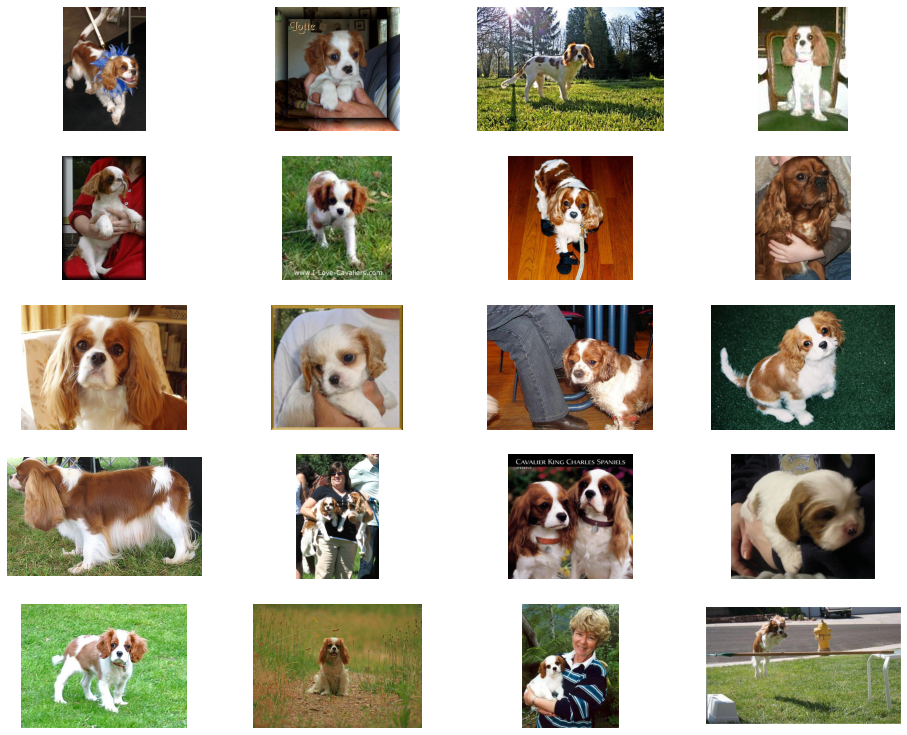

In [9]:
idx=5
print(breed_dirs_list[idx])
print_imgs(breed_dirs_list[idx], 20)

In [10]:
os.mkdir(cropped_path)

for breed_dir in breed_dirs_list:
    os.mkdir(cropped_path + "/" + breed_dir)

cropped_dirs_list = os.listdir(cropped_path)
print("создано {} папок для хранения обрезанных изображений собак по породам".format(len(cropped_dirs_list)))

создано 120 папок для хранения обрезанных изображений собак по породам


In [11]:
%%time

# для каждой папки, создать в неё соответствующее ей обрезанные изображения
for breed_name in cropped_dirs_list:
    for file in os.listdir(annots_path + "/{}".format(breed_name)):
        img = Image.open(img_folders_path + "/{}/{}.jpg".format(breed_name, file))
        
        tree = ET.parse(annots_path + "/{}/{}".format(breed_name, file))
        xmin = int(tree.getroot().findall("object")[0].find("bndbox").find("xmin").text)
        xmax = int(tree.getroot().findall("object")[0].find("bndbox").find("xmax").text)
        ymin = int(tree.getroot().findall("object")[0].find("bndbox").find("ymin").text)
        ymax = int(tree.getroot().findall("object")[0].find("bndbox").find("ymax").text)
        
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert("RGB")
        img = img.resize((224, 224))
        img.save(cropped_path + "/" + breed_name + "/" + file + ".jpg")

Wall time: 8min 36s


In [9]:
def paths_labels_targets():
    paths = list()
    labels = list()
    targets = list()
    
    for breed_name in breed_dirs_list:
        curr_breed_path = cropped_path + "/{}".format(breed_name)
        
        for img_name in os.listdir(curr_breed_path):
            paths.append(curr_breed_path + "/" + img_name)
            labels.append(breed_name)
            targets.append(dir_idx_map[breed_name])
    
    return paths, labels, targets

In [10]:
paths, labels, targets = paths_labels_targets()

In [11]:
# проверка: нет ли лишнего или упущенного
assert len(paths) == len(labels)
assert len(paths) == len(targets)

In [12]:
# чихуахуа – это чихуахуа, не является представителем остальных 119 пород,
# поэтому 1 и остальные столбцы по 0
targets = to_categorical(targets, num_classes=num_classes)
targets.shape

(20580, 120)

In [13]:
int(np.ceil(len(paths) / float(32)))

644

In [14]:
# раздутие данных на лету

# обучение с fit_generator:
# 1) получение данных партиями от generator
# 2) обновление весов модели на основе полученной партии
# 3) повторять

batch_size = 64

# Sequence are a safer way to do multiprocessing. 
# This structure guarantees that the network will only train once 
# on each sample per epoch which is not the case with generators.
class ImageGenerator(Sequence):
 
    def __init__(self, paths, targets, batch_size, shape):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        
    # Gets batch at position index.
    def __getitem__(self, idx):
        # idx – индекс партии
        # [начало:конец]: всего – batch_size (точнее, "конец минус начало") элементов
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        
        # zeros() возвращает новый массив указанной формы и типа, заполненный нулями
        # len(batch_paths)    – кол-во изображений,
        # self.shape[0] – 244 – ширина изображения,
        # self.shape[1] – 244 – высота изображения,
        # self.shape[2] –   3 – цвет в RGB
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), 
                     dtype=np.float32)
        # загружаем изображения
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        
        # len(batch_paths)    – кол-во изображений
        # num_class           – кол-во классов
        # 1                   – угадали или нет
        y = np.zeros((self.batch_size, num_classes, 1))
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        
        return x, y

    # Create a generator that iterate over the Sequence.
    # len(self)                 – возвращает кол-во партий,
    # for i in range(len(self)) – для кажддой партии
    # возвращает ПО ОДНОМУ xy каждой партии
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
                
    # Number of batch in the Sequence.
    def __len__(self):
        # ceil() округляет к большему целому числу
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __load_image(self, path):
        img = imread(path)
        # The images are converted from RGB to BGR, 
        # then each color channel is zero-centered 
        # with respect to the ImageNet dataset, without scaling.
        #
        # Когда вы загружаете одно изображение, 
        # вы получаете форму одного изображения, 
        # которое есть (size1, size2, channels).
        #
        # Note: each Keras Application expects a specific kind of input preprocessing. 
        # For DenseNet, call tf.keras.applications.densenet.preprocess_input 
        # on your inputs before passing them to the model.
        img = preprocess_input(img)
        
        return img

### Обучение шести последних слоёв

In [15]:
# test_size:
# If float, should be between 0.0 and 1.0 and  represent 
# the proportion of the dataset to include in the test split.

train_paths, test_paths, train_targets, test_targets = train_test_split(paths,
                                                  targets,
                                                  test_size=0.15, 
                                                  random_state=42)

In [16]:
train_gen = ImageGenerator(train_paths, train_targets, batch_size=32, shape=(224,224,3))
test_gen = ImageGenerator(test_paths, test_targets, batch_size=32, shape=(224,224,3))

In [10]:
# Input() is used to instantiate a Keras tensor.
img_input = Input((224, 224, 3))

# include_top:
# whether to include the fully-connected layer at the top of the network.
densenet_model = DenseNet121(input_tensor=img_input,
                       weights="imagenet",
                       include_top=False)

In [18]:
densenet_model.output

<KerasTensor: shape=(None, 7, 7, 1024) dtype=float32 (created by layer 'relu')>

### Pooling

Pooling is basically "downscaling" the image obtained from the previous layers. It can be compared to shrinking an image to reduce its pixel density. The avg for each block is computed.

When applying Global Average Pooling, the pool size is still set to the size of the layer input, the average of the pool is taken.

They’re often used to replace the fully-connected or densely-connected layers in a classifier. Instead, the model ends with a convolutional layer that generates as many feature maps as the number of target classes, and applies global average pooling to each in order to convert each feature map into one value. As feature maps can recognize certain elements within the input data, the maps in the final layer effectively learn to “recognize” the presence of a particular class in this architecture. By feeding the values generated by global average pooling into a Softmax activation function, you once again obtain the multiclass probability distribution that you want.

https://www.machinecurve.com/index.php/2020/01/30/what-are-max-pooling-average-pooling-global-max-pooling-and-global-average-pooling/#what-are-pooling-operations

### Dense

The dense layer is a neural network layer that is connected deeply, which means each neuron in the dense layer receives input from all neurons of its previous layer.

In the background, the dense layer performs a matrix-vector multiplication. The values used in the matrix are actually parameters that can be trained and updated with the help of backpropagation.

The output generated by the dense layer is an ‘m’ dimensional vector. Thus, dense layer is basically used for changing the dimensions of the vector. Dense layers also applies operations like rotation, scaling, translation on the vector.

```units``` – The most basic parameter of all the parameters, it uses positive integer as it value and represents the output size of the layer.

https://machinelearningknowledge.ai/keras-dense-layer-explained-for-beginners/#What_is_a_Dense_Layer_in_Neural_Network

Dense implements the operation: ```output = activation(dot(input, kernel) + bias)``` where ```activation``` is the element-wise ```activation``` function passed as the activation argument, ```kernel``` is a weights matrix created by the layer, and bias is a ```bias``` vector created by the layer (only applicable if ```use_bias``` is ```True```).

https://keras.io/api/layers/core_layers/dense/

### Dropout

Dropout Layer is one of the most popular regularization techniques to reduce overfitting in the deep learning models. Overfitting in the model occurs when it shows more accuracy on the training data but less accuracy on the test data or unseen data.

In the dropout technique, some of the neurons in hidden or visible layers are dropped or omitted randomly. The experiments show that this dropout technique regularizes the neural network model to produce a robust model which does not overfit.

```rate``` − This represents the fraction of the input unit to be dropped. It will be from 0 to 1.

https://machinelearningknowledge.ai/keras-dropout-layer-explained-for-beginners/

In [17]:
# Output -> Pooling -> Dense -> Dropout -> Dense -> Dropout - > Dense

x = densenet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
classes_output = Dense(num_classes, activation="softmax")(x)

model = Model(img_input, classes_output)

In [20]:
for layer in model.layers[:-6]:
    layer.trainable = False

### Adam

Стохастический градиентный спуск поддерживает единую скорость обучения (называемую альфа) для всех обновлений веса, и скорость обучения не изменяется во время тренировки.

Скорость обучения поддерживается для каждого веса сети (параметра) и отдельно адаптируется по мере развития обучения.

Метод вычисляет индивидуальные адаптивные скорости обучения для различных параметров из оценок первого и второго моментов градиентов.

### Accuracy

Accuracy — доля правильных ответов алгоритма.

### Categorical Cross Entropy

Перекрёстная энтропия.

In [18]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["acc"])

### Подключение и проверка видеокарты

https://www.tensorflow.org/install/gpu

In [22]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1



In [24]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [25]:
tf.test.gpu_device_name()

'/device:GPU:0'

### Обучение

In [26]:
%%time

history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=test_gen, 
                              validation_steps=len(test_gen),
                              epochs=20)

Epoch 1/20
547/547 [==============================] - 779s 1s/step - loss: 3.2730 - acc: 0.2576 - val_loss: 0.7192 - val_acc: 0.7619
Epoch 2/20
547/547 [==============================] - 138s 252ms/step - loss: 1.1302 - acc: 0.6559 - val_loss: 0.6087 - val_acc: 0.8037
Epoch 3/20
547/547 [==============================] - 135s 247ms/step - loss: 0.9435 - acc: 0.7094 - val_loss: 0.5689 - val_acc: 0.8115
Epoch 4/20
547/547 [==============================] - 137s 251ms/step - loss: 0.8924 - acc: 0.7210 - val_loss: 0.5735 - val_acc: 0.8160
Epoch 5/20
547/547 [==============================] - 138s 253ms/step - loss: 0.8325 - acc: 0.7403 - val_loss: 0.5503 - val_acc: 0.8205
Epoch 6/20
547/547 [==============================] - 140s 255ms/step - loss: 0.7657 - acc: 0.7600 - val_loss: 0.5446 - val_acc: 0.8238
Epoch 7/20
547/547 [==============================] - 139s 253ms/step - loss: 0.7475 - acc: 0.7650 - val_loss: 0.5087 - val_acc: 0.8319
Epoch 8/20
547/547 [==============================]

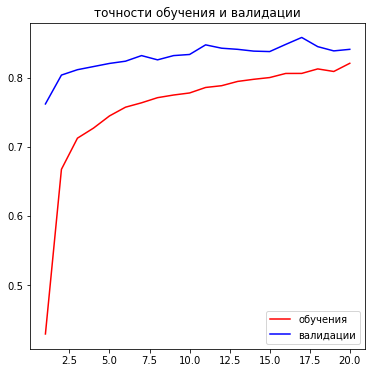

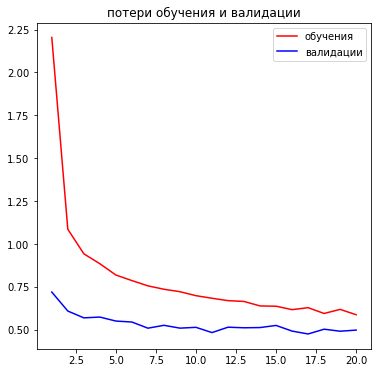

In [29]:
# figure size in inches
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.title('точности обучения и валидации')
plt.plot(epochs, acc, 'red', label='обучения')
plt.plot(epochs, val_acc, 'blue', label='валидации')
plt.legend() # нарисовать легенду

plt.figure() # новый рисунок
plt.title('потери обучения и валидации')
plt.plot(epochs, loss, 'red', label='обучения')
plt.plot(epochs, val_loss, 'blue', label='валидации')
plt.legend()

plt.show()

# Обучение всех слоёв

In [30]:
for layer in model.layers[:]:
    layer.trainable = True

### ModelCheckpoint

Callback to save the Keras model or model weights at some frequency.

ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

```monitor``` – The metric name to monitor.
Prefix the name with ```val_``` to monitor validation metrics.

```verbose=0``` will show you nothing (silent).
```verbose=1``` will show you an animated progress bar.

```save_best_only```: if ```save_best_only=True```, it only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten. 
If filepath doesn't contain formatting options like {epoch} then filepath will be overwritten by each new better model.

```mode```: one of {'auto', 'min', 'max'}. If ```save_best_only=True```, the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. 
For ```val_acc```, this should be ```max```, for ```val_loss``` this should be ```min```, etc. In ```auto``` mode, the direction is automatically inferred from the name of the monitored quantity.

https://keras.io/api/callbacks/model_checkpoint/

In [31]:
# a check point callback to save our best weights
checkpoint = ModelCheckpoint("dog-breed-classifier-weights.h5", 
                             monitor="val_acc", 
                             verbose=1, 
                             save_best_only=True, 
                             mode="max", 
                             save_weights_only=True)

### ReduceLROnPlateau

Reduce learning rate when a metric has stopped improving.

Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
 
```monitor```: quantity to be monitored.

```factor```: factor by which the learning rate will be reduced. ```new_lr = lr * factor```.

```patience```: number of epochs with no improvement after which learning rate will be reduced.

```verbose```: int. 0: quiet, 1: update messages.

```mode```: one of {'auto', 'min', 'max'}. 
In 'min' mode, the learning rate will be reduced when the quantity monitored has stopped decreasing; 
in 'max' mode it will be reduced when the quantity monitored has stopped increasing; 
in 'auto' mode, the direction is automatically inferred from the name of the monitored quantity.

```min_delta```: threshold for measuring the new optimum, to only focus on significant changes.

```cooldown```: number of epochs to wait before resuming normal operation after lr has been reduced.

```min_lr```: lower bound on the learning rate.
 
https://keras.io/api/callbacks/reduce_lr_on_plateau/

In [32]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", 
                              factor=0.2,
                              patience=1, 
                              verbose=1, 
                              mode="min",
                              min_delta=0.0001, 
                              cooldown=2, 
                              min_lr=1e-7)

### EarlyStopping

Stop training when a monitored metric has stopped improving.

Assuming the goal of a training is to minimize the loss. With this, the metric to be monitored would be ```loss```, and mode would be ```min```. 

A ```model.fit()``` training loop will check at end of every epoch whether the loss is no longer decreasing, considering the ```min_delta``` and ```patience``` if applicable. Once it's found no longer decreasing, model.stop_training is marked True and the training terminates.

```patience```: Number of epochs with no improvement after which training will be stopped.

https://keras.io/api/callbacks/early_stopping/

In [33]:
early_stop = EarlyStopping(monitor="val_loss", 
                           mode="min",
                           patience=5)

In [34]:
history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=test_gen, 
                              validation_steps=len(test_gen),
                              epochs=20,
                              callbacks=[checkpoint, reduce_lr, early_stop])

Epoch 1/20
547/547 [==============================] - 292s 534ms/step - loss: 0.6036 - acc: 0.8136 - val_loss: 0.5057 - val_acc: 0.8419

Epoch 00001: val_acc improved from -inf to 0.84192, saving model to dog-breed-classifier-model.h5
Epoch 2/20
547/547 [==============================] - 139s 254ms/step - loss: 0.5787 - acc: 0.8172 - val_loss: 0.4994 - val_acc: 0.8520

Epoch 00002: val_acc improved from 0.84192 to 0.85196, saving model to dog-breed-classifier-model.h5
Epoch 3/20
547/547 [==============================] - 138s 253ms/step - loss: 0.5758 - acc: 0.8205 - val_loss: 0.4975 - val_acc: 0.8503

Epoch 00003: val_acc did not improve from 0.85196
Epoch 4/20
547/547 [==============================] - 138s 253ms/step - loss: 0.5590 - acc: 0.8267 - val_loss: 0.5413 - val_acc: 0.8312

Epoch 00004: val_acc did not improve from 0.85196

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/20
547/547 [==============================] - 139s 254ms/step -

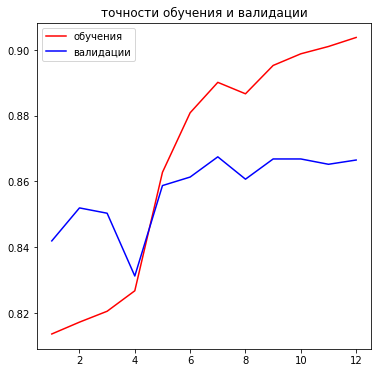

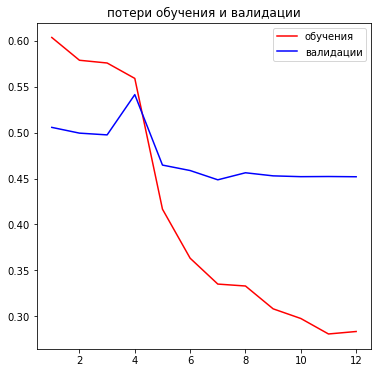

In [35]:
plt.rcParams["figure.figsize"] = (6,6)

acc = history.history["acc"]
val_acc = history.history["val_acc"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.title("точности обучения и валидации")
plt.plot(epochs, acc, "red", label='обучения')
plt.plot(epochs, val_acc, "blue", label="валидации")
plt.legend()

plt.figure()
plt.title("потери обучения и валидации")
plt.plot(epochs, loss, "red", label="обучения")
plt.plot(epochs, val_loss, "blue", label="валидации")
plt.legend()

plt.show()

In [36]:
print(max(val_acc))

0.8675088882446289


In [30]:
# model.load_weights("D:\YandexDisk\models\dog-breed-classifier-weights.h5")
# или
# model.load("D:\YandexDisk\models\dog-breed-classifier-model.h5")

In [21]:
def download_and_predict(url, file_name):
    os.system("curl -s {} -o {}".format(url, file_name))
    img = Image.open(file_name)
    img = img.convert("RGB")
    img = img.resize((224, 224))
    img.save(file_name)

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")

    img = imread(file_name)
    img = preprocess_input(img)
    img.shape
    img = np.expand_dims(img, axis=0)
    img.shape
    probs = model.predict(img)
    
    # отсортировать по возрастанию, выбрать пять с конца
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", idx_dir_map[idx].split("-")[-1])

99.05% 	 Norwegian_elkhound
0.61% 	 Siberian_husky
0.20% 	 malamute
0.14% 	 Eskimo_dog
0.00% 	 German_shepherd


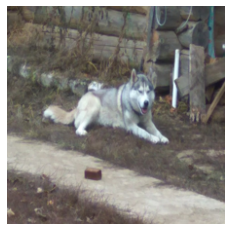

In [62]:
download_and_predict("https://i.imgur.com/I642rMd.jpg",
                     "test-1.jpg")

76.66% 	 Siberian_husky
17.34% 	 Eskimo_dog
5.33% 	 malamute
0.61% 	 Norwegian_elkhound
0.02% 	 dingo


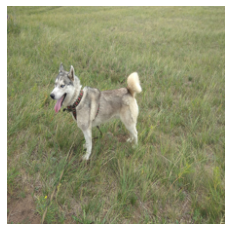

In [25]:
download_and_predict("https://i.imgur.com/1ch8hwo.jpg",
                     "test-2.jpg")


64.89% 	 Siberian_husky
21.64% 	 Eskimo_dog
13.45% 	 malamute
0.01% 	 Norwegian_elkhound
0.00% 	 German_shepherd


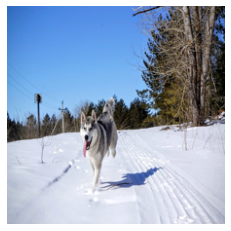

In [24]:
download_and_predict("https://i.imgur.com/YnGCP6Q.jpg",
                     "test-3.jpg")

99.99% 	 Pomeranian
0.01% 	 keeshond
0.00% 	 toy_poodle
0.00% 	 Chihuahua
0.00% 	 Pekinese


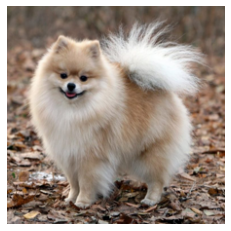

In [27]:
download_and_predict("https://i.imgur.com/QzxTOG1.jpg",
                     "test-4.jpg")

99.69% 	 Doberman
0.26% 	 miniature_pinscher
0.05% 	 tan_coonhound
0.00% 	 toy_terrier
0.00% 	 Mexican_hairless


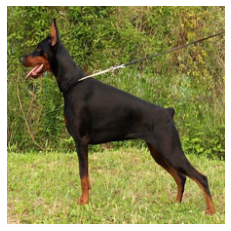

In [31]:
download_and_predict("https://upload.wikimedia.org/wikipedia/commons/7/7a/European_Dobermann.jpg",
                     "test-5.jpg")

99.99% 	 pug
0.00% 	 bull_mastiff
0.00% 	 Brabancon_griffon
0.00% 	 Tibetan_mastiff
0.00% 	 Norwegian_elkhound


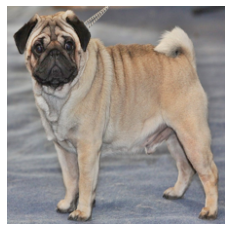

In [32]:
download_and_predict("https://upload.wikimedia.org/wikipedia/commons/f/f0/Mops_oct09_cropped2.jpg",
                     "test-6.jpg")

100.00% 	 chow
0.00% 	 Tibetan_mastiff
0.00% 	 Samoyed
0.00% 	 Pomeranian
0.00% 	 Newfoundland


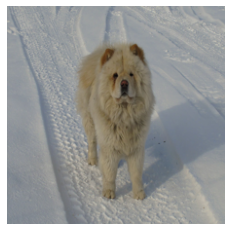

In [33]:
download_and_predict("https://upload.wikimedia.org/wikipedia/commons/c/c7/ChowChow1.jpg",
                     "test-7.jpg")